In [1]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
stemmer = PorterStemmer()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from xgboost import XGBClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


In [2]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv')
df_test = pd.read_csv('../input/nlp-getting-started/test.csv')
print('Training data shape (rows, cols): ', df_train.shape)
df_train.head()
print("****Train Data Info****")
df_train.info()

Training data shape (rows, cols):  (7613, 5)
****Train Data Info****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
print('Test data shape (rows, cols): ', df_test.shape)
df_test.head()
print("****Test Data Info****")
df_test.info()

Test data shape (rows, cols):  (3263, 4)
****Test Data Info****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [4]:
print (df_train.keyword.nunique(), df_test.keyword.nunique())
print ("Difference: ", set(df_train.keyword.unique()) - set(df_test.keyword.unique()))

221 221
Difference:  set()


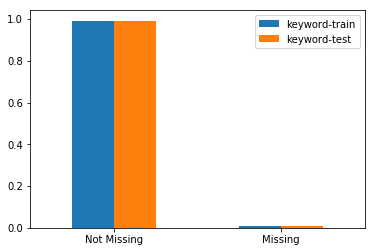

In [5]:
index = ['Not Missing', 'Missing']
keyword_train = df_train['keyword'].isnull().value_counts()/df_train.shape[0]
keyword_test = df_test['keyword'].isnull().value_counts()/df_test.shape[0]
df = pd.DataFrame({'keyword-train': [keyword_train[0],keyword_train[1]],'keyword-test': [keyword_test[0],keyword_test[1]]}, index=index)
ax = df.plot.bar(rot=0)

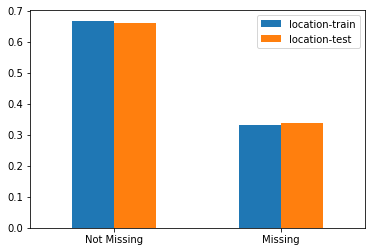

In [6]:
location_train = df_train['location'].isnull().value_counts()/df_train.shape[0]
location_test = df_test['location'].isnull().value_counts()/df_test.shape[0]
df = pd.DataFrame({'location-train': [location_train[0],location_train[1]],'location-test': [location_test[0],location_test[1]]}, index=index)
ax = df.plot.bar(rot=0)

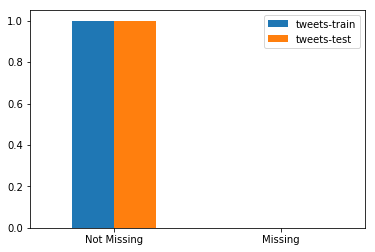

In [7]:
tweets_train = df_train['text'].isnull().value_counts()/df_train.shape[0]
tweets_test = df_test['text'].isnull().value_counts()/df_test.shape[0]
df = pd.DataFrame({'tweets-train': [tweets_train[0],0],'tweets-test': [tweets_test[0],0]}, index=index)
ax = df.plot.bar(rot=0)

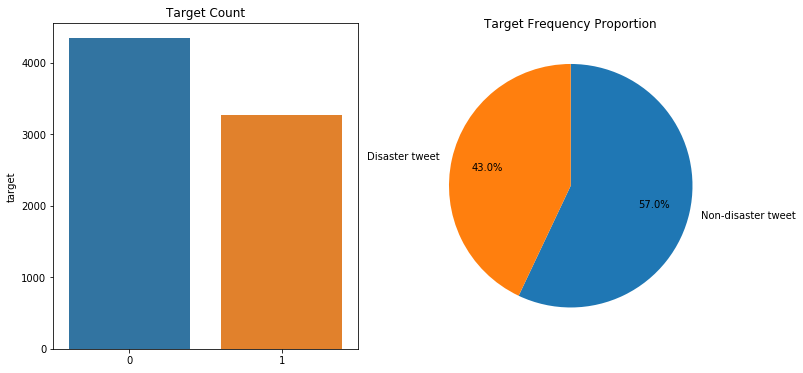

In [8]:
# Target Distribution (0 or 1)
dist_class = df_train['target'].value_counts()
labels = ['Non-disaster tweet', 'Disaster tweet']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax2.pie(dist_class,
        labels=labels,
        counterclock=False,
        startangle=90,
        autopct='%1.1f%%',
        pctdistance=0.7)

sns.barplot(x=dist_class.index, y=dist_class, ax=ax1).set_title("Target Count")

plt.title("Target Frequency Proportion")
plt.show()

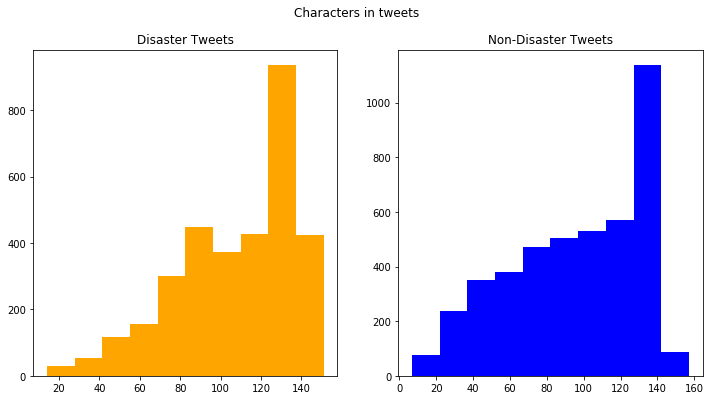

In [9]:
disaster_tweet_length = df_train[df_train['target']==1]['text'].str.len()
nondisaster_tweet_length = df_train[df_train['target']==0]['text'].str.len()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.hist(disaster_tweet_length, color='orange')
ax1.set_title("Disaster Tweets")

ax2.hist(nondisaster_tweet_length, color='blue')
ax2.set_title("Non-Disaster Tweets")

fig.suptitle("Characters in tweets")
plt.show()

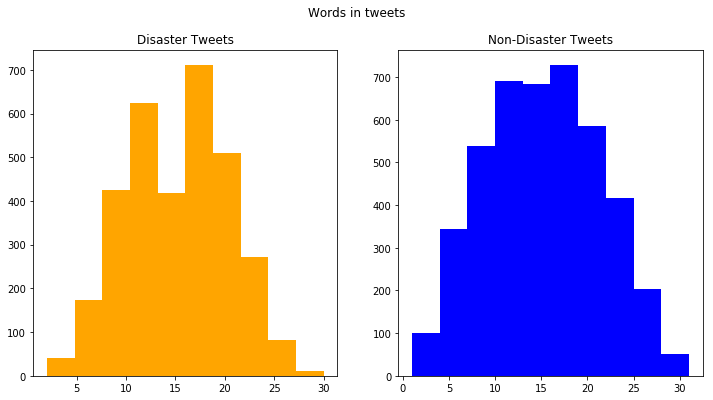

In [10]:
disaster_tweet_words = df_train[df_train['target']==1]['text'].str.split().map(lambda x: len(x))
nondisaster_tweet_words = df_train[df_train['target']==0]['text'].str.split().map(lambda x: len(x))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.hist(disaster_tweet_words, color='orange')
ax1.set_title("Disaster Tweets")

ax2.hist(nondisaster_tweet_words, color='blue')
ax2.set_title("Non-Disaster Tweets")

fig.suptitle("Words in tweets")
plt.show()

In [11]:
df_train_keyword = pd.DataFrame({
    'keyword': df_train['keyword'].value_counts().index,
    'count': df_train['keyword'].value_counts().values
})

px.bar(
    df_train_keyword,
    x='keyword',
    y='count',
    title="Each unique keyword count in training data",
).show()


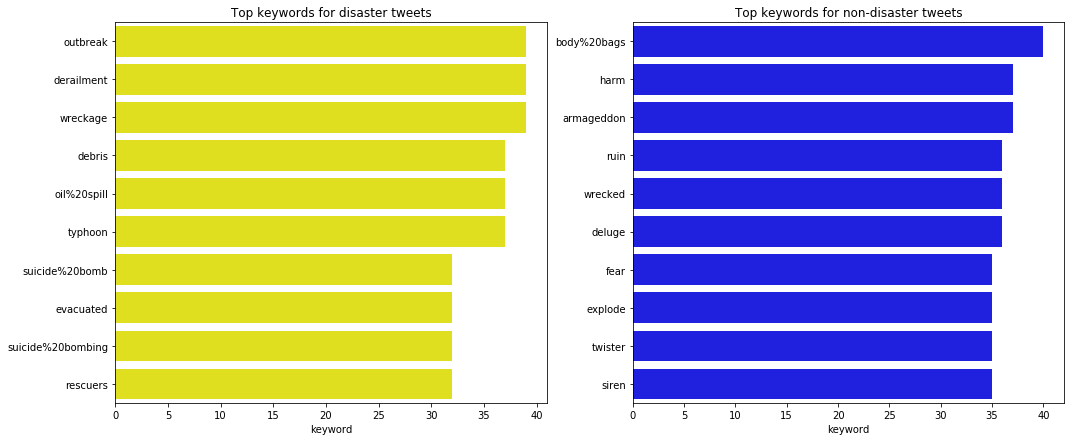

In [12]:
kw_d = df_train[df_train.target==1].keyword.value_counts().head(10)
kw_nd = df_train[df_train.target==0].keyword.value_counts().head(10)

plt.figure(figsize=(17,7))
plt.subplot(121)
sns.barplot(kw_d, kw_d.index, color='yellow')
plt.title('Top keywords for disaster tweets')
plt.subplot(122)
sns.barplot(kw_nd, kw_nd.index, color='b')
plt.title('Top keywords for non-disaster tweets')
plt.show()

There is no common top 10 keywords between disaster and non-disaster tweets.

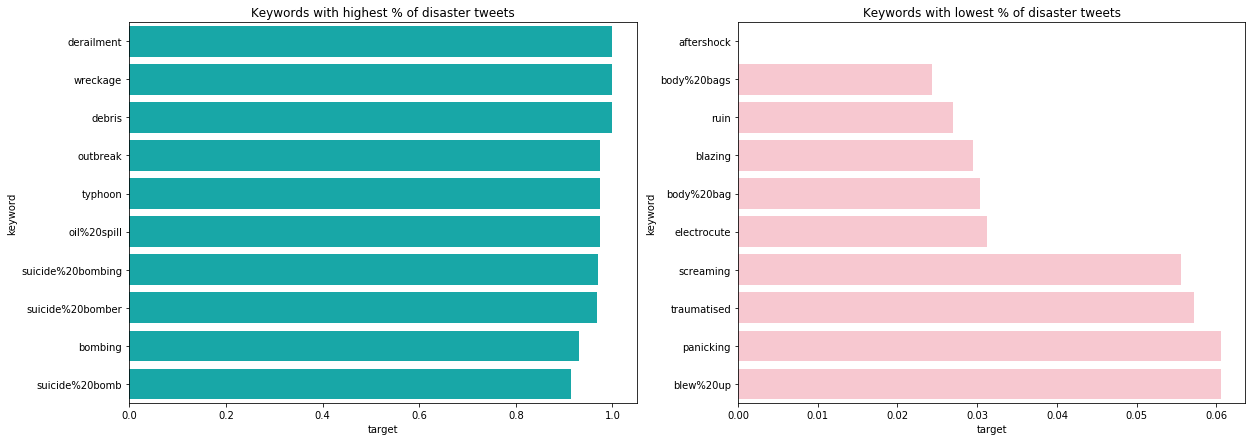

In [13]:
top_d = df_train.groupby('keyword').mean()['target'].sort_values(ascending=False).head(10)
top_nd = df_train.groupby('keyword').mean()['target'].sort_values().head(10)

plt.figure(figsize=(20,7))
plt.subplot(121)
sns.barplot(top_d, top_d.index, color='c')
plt.title('Keywords with highest % of disaster tweets')
plt.subplot(122)
sns.barplot(top_nd, top_nd.index, color='pink')
plt.title('Keywords with lowest % of disaster tweets')
plt.show()

In [14]:
df_train_location = pd.DataFrame({
    'location': df_train['location'].value_counts().index,
    'count': df_train['location'].value_counts().values
})
px.bar(
    df_train_location,
    x=df_train_location['location'][:20],
    y=df_train_location['count'][:20],
    title="Top 20 location countin training data"
).show()

Word Cloud for Disaster Tweets


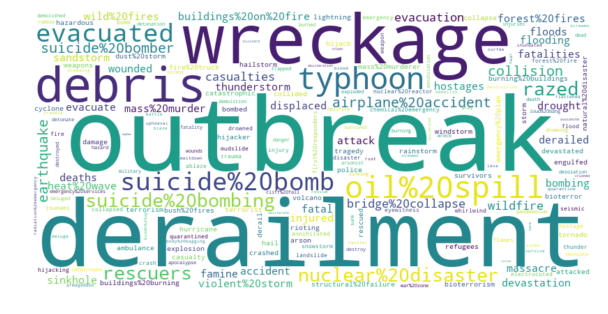

In [15]:
print("Word Cloud for Disaster Tweets")
disaster_tweet = dict(df_train[df_train['target']==1]['keyword'].value_counts())

stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color="white").generate_from_frequencies(disaster_tweet)

plt.figure(figsize=[10,6])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Word Cloud for Non-Disaster Tweets


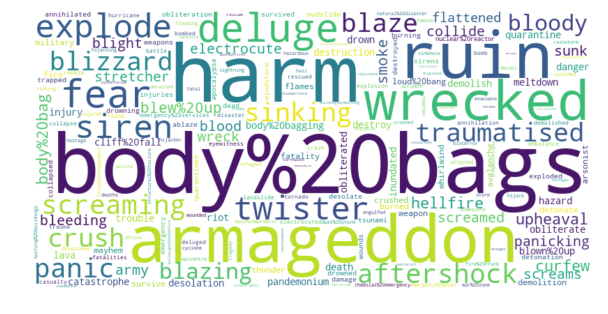

In [16]:
print("Word Cloud for Non-Disaster Tweets")
nondisaster_tweet = dict(df_train[df_train['target']==0]['keyword'].value_counts())

wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color="white").generate_from_frequencies(nondisaster_tweet)

plt.figure(figsize=[10,6])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Word Cloud for Test Data


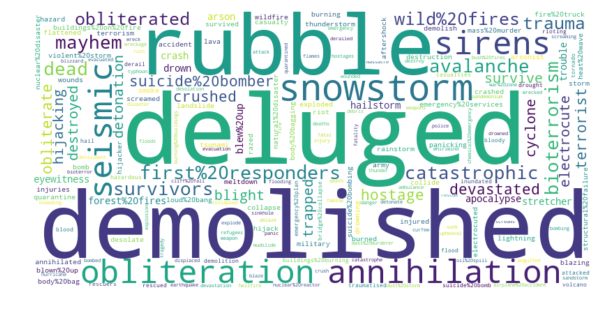

In [17]:
print("Word Cloud for Test Data")
test_tweet = dict(df_test['keyword'].value_counts())

wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color="white").generate_from_frequencies(test_tweet)

plt.figure(figsize=[10,6])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [18]:
import re

test_str = df_train.loc[417, 'text']

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text

def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    # df['hashtags'].fillna(value='no', inplace=True)
    # df['mentions'].fillna(value='no', inplace=True)
    
    return df
    
train = process_text(df_train)
test = process_text(df_test)

In [19]:
from wordcloud import STOPWORDS
import string
def create_stat(df):
    # Tweet length
    df['text_len'] = df['text_clean'].apply(len)
    # Word count
    df['word_count'] = df["text_clean"].apply(lambda x: len(str(x).split()))
    # Stopword count
    df['stop_word_count'] = df['text_clean'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    # Punctuation count
    df['punctuation_count'] = df['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    # Count of hashtags (#)
    df['hashtag_count'] = df['hashtags'].apply(lambda x: len(str(x).split()))
    # Count of mentions (@)
    df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
    # Count of links
    df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
    # Count of uppercase letters
    df['caps_count'] = df['text_clean'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    # Ratio of uppercase letters
    df['caps_ratio'] = df['caps_count'] / df['text_len']
    return df

train = create_stat(df_train)
test = create_stat(test)


In [20]:
print("All of the statistics have very low correlation with the target variable")
train.corr()['target'].drop('target').sort_values()

All of the statistics have very low correlation with the target variable


stop_word_count     -0.111250
mention_count       -0.049654
caps_ratio          -0.014970
punctuation_count   -0.012535
word_count           0.017081
link_count           0.020244
caps_count           0.027808
hashtag_count        0.032853
id                   0.060781
text_len             0.096435
Name: target, dtype: float64

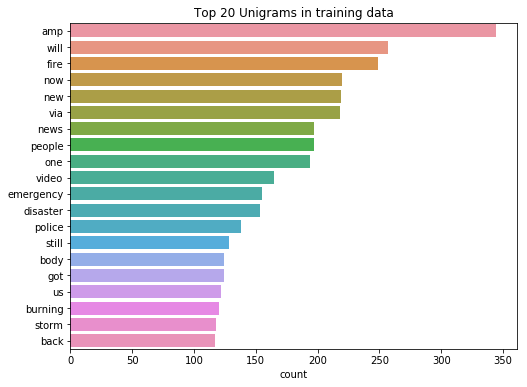

In [21]:
from nltk import FreqDist, word_tokenize
stopwords = set(STOPWORDS)
word_freq = FreqDist(w for w in word_tokenize(' '.join(train['text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count',ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(top20w['count'], top20w.index)
plt.title('Top 20 Unigrams in training data')
plt.show()

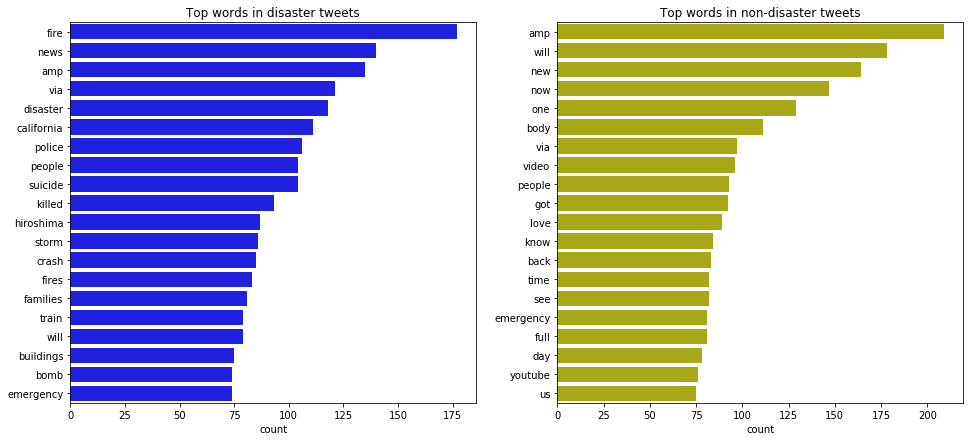

In [22]:
plt.figure(figsize=(16,7))
plt.subplot(121)
freq_d = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==1, 'text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_d = pd.DataFrame.from_dict(freq_d, orient='index', columns=['count'])
top20_d = df_d.sort_values('count',ascending=False).head(20)
sns.barplot(top20_d['count'], top20_d.index, color='b')
plt.title('Top words in disaster tweets')
plt.subplot(122)
freq_nd = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==0, 'text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_nd = pd.DataFrame.from_dict(freq_nd, orient='index', columns=['count'])
top20_nd = df_nd.sort_values('count',ascending=False).head(20)
sns.barplot(top20_nd['count'], top20_nd.index, color='y')
plt.title('Top words in non-disaster tweets')
plt.show()

Findings:

*  fire and news which are the top 2 disaster words in tweers, dont make to top 20 on non-disaster tweets
* Words like 'califonia', 'hiroshima', 'fire', 'police', 'suicide', 'bomb' etc are more specific for real disaster tweets.

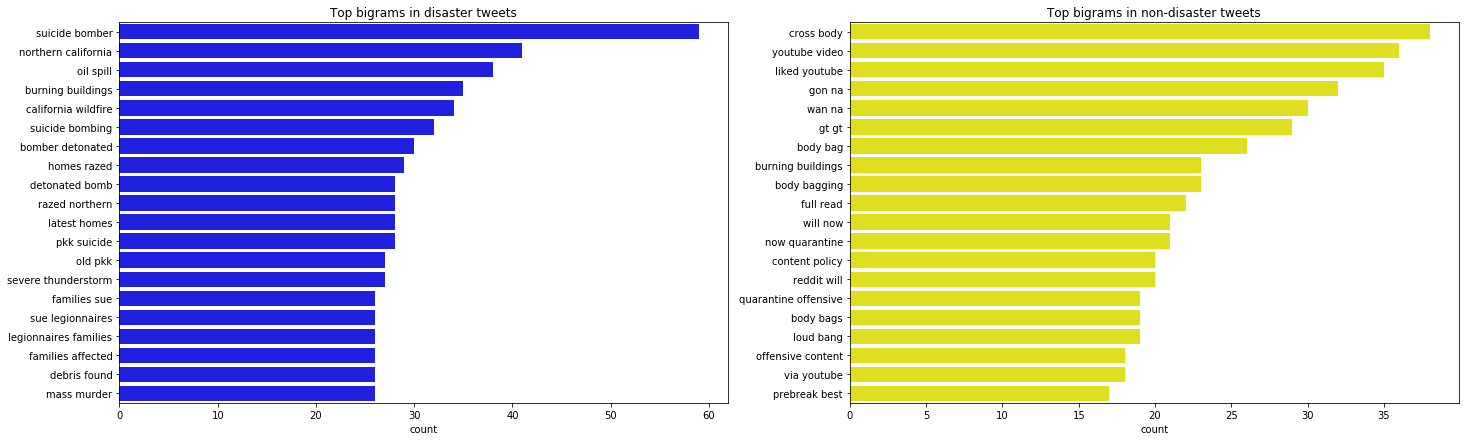

In [23]:
# Bigrams

from nltk import bigrams

plt.figure(figsize=(24,7))
plt.subplot(121)
bigram_d = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==1, 'text_clean']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
d_fq = FreqDist(bg for bg in bigram_d)
bgdf_d = pd.DataFrame.from_dict(d_fq, orient='index', columns=['count'])
bgdf_d.index = bgdf_d.index.map(lambda x: ' '.join(x))
bgdf_d = bgdf_d.sort_values('count',ascending=False)
sns.barplot(bgdf_d.head(20)['count'], bgdf_d.index[:20], color='blue')
plt.title('Top bigrams in disaster tweets')
plt.subplot(122)
bigram_nd = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==0, 'text_clean']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
nd_fq = FreqDist(bg for bg in bigram_nd)
bgdf_nd = pd.DataFrame.from_dict(nd_fq, orient='index', columns=['count'])
bgdf_nd.index = bgdf_nd.index.map(lambda x: ' '.join(x))
bgdf_nd = bgdf_nd.sort_values('count',ascending=False)
sns.barplot(bgdf_nd.head(20)['count'], bgdf_nd.index[:20], color='yellow')
plt.title('Top bigrams in non-disaster tweets')
plt.show()

Findings:

* Most top bigrams like suicide bomber, oil spill, california wildfire in disaster tweets show certain kinds of calamity
* For non-disaster tweets, only 'burning buildings' as top bigram look like a disaster
* Top bigrams in disaster tweets have a more casual tone
* 'youtube' appears in three of the twenty bigrams for non-disaster tweets and none in disaster tweets

In [24]:
# Fill NA values
for col in ['keyword','location']:
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

def clean_loc(x):
    if x == 'None':
        return 'None'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Seattle' in x:
        return 'Seattle'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'Toronto' in x:
        return 'Toronto'
    elif 'Sacramento' in x:
        return 'Sacramento'
    elif 'Atlanta' in x:
        return 'Atlanta'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'Texas' in x:
        return 'Texas'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Indonesia' in x:
        return 'Indonesia'
    elif x in top_loc:
        return x
    else: return 'Others'
    
train['location_clean'] = train['location'].apply(lambda x: clean_loc(str(x)))
test['location_clean'] = test['location'].apply(lambda x: clean_loc(str(x)))

NameError: name 'top_loc' is not defined

In [25]:
_ = (X_train_link.transpose().dot(train['target']) / X_train_link.sum(axis=0)).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=_, y=_.index)
plt.axvline(np.mean(train.target))
plt.title('% of disaster tweet given links')
plt.show()

NameError: name 'X_train_link' is not defined

In [26]:
_ = (X_train_men.transpose().dot(train['target']) / X_train_men.sum(axis=0)).sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=_.index, y=_)
plt.axhline(np.mean(train.target))
plt.title('% of disaster tweet given mentions')
plt.xticks(rotation = 50)
plt.show()

NameError: name 'X_train_men' is not defined

In [27]:
hash_rank = (X_train_hash.transpose().dot(train['target']) / X_train_hash.sum(axis=0)).sort_values(ascending=False)
print('Hashtags with which 100% of Tweets are disasters: ')
print(list(hash_rank[hash_rank==1].index))
print('Total: ' + str(len(hash_rank[hash_rank==1])))
print('Hashtags with which 0% of Tweets are disasters: ')
print(list(hash_rank[hash_rank==0].index))
print('Total: ' + str(len(hash_rank[hash_rank==0])))

NameError: name 'X_train_hash' is not defined